In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import statsmodels.api as sm
import os.path
import pickle

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

In [2]:
utils = importr("MARSS")

# Data

## Regressors

In [3]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

In [4]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


,BZGDINDX Index,BZIPTLYo Index,MPMIBRMA Index,BZGDGNDI Index,BZUETOTN Index,BFOETTOD Index,BZGDFNCE Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2017-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66190.63,53.78,10.6000,10.9178,475.0,NaN,NaN,NaN
2017-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66033.98,53.17,10.5096,10.8762,-474.0,NaN,NaN,NaN
2017-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64301.73,52.63,10.5724,10.8627,NaN,NaN,NaN,NaN
2017-01-31,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,79.3,64670.78,52.81,10.5262,10.8029,NaN,NaN,NaN,NaN
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65084.65,53.74,10.4928,10.8046,NaN,NaN,NaN,NaN


In [5]:
data.loc[data.index[-1]].notnull().any()

True

### Cut Sample 

In [6]:
# del data["ibov index"]
# del df["ibov index"]

In [7]:
data.index.min()

Timestamp('2000-01-05 00:00:00')

In [8]:
data.index.max()

Timestamp('2017-02-01 00:00:00')

### Transformations


In [9]:
data.columns

Index(['BZGDINDX Index', 'BZIPTLYo Index', 'MPMIBRMA Index', 'BZGDGNDI Index',
       'BZUETOTN Index', 'BFOETTOD Index', 'BZGDFNCE Index', 'BZREELHT Index',
       'BPPICM Index', 'BZPIIPCM Index', 'BZEXTOT$ Index', 'BZTBBALY INDEX',
       'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX', 'ibov index',
       'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy', 'BZMOTRFB INDEX',
       'BZJCGTOT INDEX', 'BZEANSA INDEX', 'OEBRD002 INDEX'],
      dtype='object')

In [10]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname="Plan2",)
transf.set_index("Code",inplace=True)

In [11]:
for s in transf.index[transf["Log"]==True]:
    data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    data[s] = data[s].diff(3)

C:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1251: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [12]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Standardize


In [13]:
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

### Stationarity

In [14]:
# For now we'll drop quarterly series
data.drop("BZGDGNDI Index",axis=1,inplace=True)
data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("ibov index",axis=1,inplace=True)
# data.drop("CL1 Comdty",axis=1,inplace=True)
# data.drop("BCSWLPD CURNCY",axis=1,inplace=True)
# data.drop("bcswfpd curncy",axis=1,inplace=True)
# data.drop("BZEXTOT$ Index",axis=1,inplace=True)
# data.drop("BZTBBALY INDEX",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)

In [15]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

BZGDINDX Index
BZGDINDX Index 's p-value is: 0.979876753696
BZIPTLYo Index
MPMIBRMA Index
BZUETOTN Index
BZUETOTN Index 's p-value is: 0.553154193243
BFOETTOD Index
BFOETTOD Index 's p-value is: 0.938465996487
BZREELHT Index
BPPICM Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
Error
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCGTOT INDEX
BZJCGTOT INDEX 's p-value is: 0.262826717701
BZEANSA INDEX
BZEANSA INDEX 's p-value is: 0.200279351294
OEBRD002 INDEX
OEBRD002 INDEX 's p-value is: 0.52204764302


# Dimensions

In [16]:
dataQ = data[["BZGDINDX Index"]]
data.drop("BZGDINDX Index",axis=1,inplace=True)

In [17]:
T = data.shape[0]
T

206

In [18]:
n = (data.columns | dataQ.columns).shape[0]
n

21

In [19]:
nm = (data.columns).shape[0]
nm

20

In [20]:
nq = (dataQ.columns).shape[0]
nq

1

In [21]:
m = 5 + nm + 5 * nq
m

30

# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [22]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

(21, 206)

# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [23]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

(20, 30)

In [24]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)


In [25]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

(21, 30)

In [26]:
# trying to impose restriction described in p 13-14 about identifying the model
Z.iloc[0,0] = 1
Z

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MPMIBRMA Index_loading,0,0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BZUETOTN Index_loading,0,0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BFOETTOD Index_loading,0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BZREELHT Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BPPICM Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,BZPIIPCM Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,BZEXTOT$ Index_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,BZTBBALY INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,BZBXPBCM INDEX_loading,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## B Matrix

$B$ matrix is $m \times m$

In [27]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

(30, 30)

## Q Matrix

$Q_t$ is $m \times m$


In [28]:
u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)
u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

In [29]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]
Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

(30, 30)

In [30]:
Q

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,Q_0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,Q_5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,Q_6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,Q_7,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,Q_8,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,Q_9,...,0,0,0,0,0,0,0,0,0,0


# Estimation without initial values

In [31]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [32]:
B.shape

(30, 30)

In [33]:
Z.shape

(21, 30)

In [34]:
y.shape

(21, 206)

In [35]:
Q.shape

(30, 30)

In [36]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n

# print(dim(Zi))
# Zi=matrix(Zi,n,m)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)

# print(dim(Zi))
# print(dim(Bi))
# print(dim(Qi))


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

# kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
# # kemfit = MARSS(yi, model=model.gen)

# # states = kemfit$states
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")

In [37]:
print(dt.datetime.now())

2017-03-20 13:48:22.533745


# Initial Values

## PCA

In [38]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.29463642]


In [39]:
components.set_index(y.transpose().index,inplace=True)
components.shape

(206, 1)

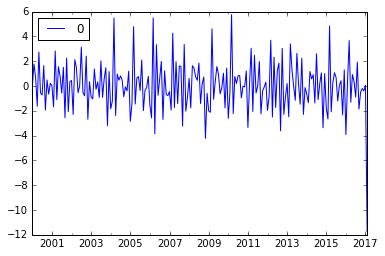

In [40]:
pd.DataFrame(components).plot()

## OLS for $\Lambda$ estimation

In [41]:
data.head()

,BZIPTLYo Index,MPMIBRMA Index,BZUETOTN Index,BFOETTOD Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.431977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,-1.506142,1.320503,NaN,NaN,0.390118,NaN,1.182906,0.858100,NaN,0.851717,NaN,NaN,NaN,0.066661
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.853446,0.571225,NaN,NaN,-0.173015,NaN,0.041820,1.096984,NaN,-0.164548,NaN,NaN,NaN,0.278830
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.051211,-0.578228,NaN,NaN,-1.833671,NaN,-0.809702,-1.649797,NaN,-0.850857,NaN,NaN,NaN,-0.024076
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,-4.688337,1.427010,1.13471,NaN,1.204858,NaN,1.071651,1.281271,NaN,1.898712,NaN,NaN,NaN,0.278789


In [42]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [43]:
coefList = []
for s in data.columns:
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

In [44]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [45]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


In [46]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

# Estimation With Initial Values

In [47]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)

# Next two lines are only useful when the restriction is effective
Z0 = Z0 * (1/Z0.iloc[0,0]) 
Z0.drop(0,axis=0,inplace=True)

Z0

,0
1,-0.144885
2,-0.163762
3,-0.072801
4,-0.258506
5,-0.075967
6,-0.182365
7,1.049410
8,0.375688
9,0.478731
10,0.044493


In [48]:
x0i = np.zeros((m,1))
x0i[0,0] = components[0][0]
x0i = pd.DataFrame(x0i)
x0i

,0
0,-0.025409
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [49]:
Z0i = Z0.as_matrix().T.flatten()

In [50]:
x0i = x0i.as_matrix().flatten()

In [51]:
def runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,maxit):
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
prediction = predict(kemfit,n.ahead=10,se.fit=FALSE)
print(attributes(prediction))

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
#     dic = {}
#     dic[]'vintage'} = yi
    return robjects.r.prediction

In [52]:
# pred = runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,5)

In [53]:
# robjects.r['states1']
# robjects.r('attributes(prediction)')

In [54]:
# robjects.r('print(prediction$method)')

In [55]:
print(dt.datetime.now())

2017-03-20 13:48:23.044117


In [56]:
# iters = [20,50,100,150,300,500,1000]
# # iters = [20,50,100,150]
# # iters = [20,50,100]
# stateslist = []
# for i in iters:
#     stateslist.append(runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,i))
#     print("done {maxiters}".format(maxiters=i))
#     print(dt.datetime.now())

In [57]:
print(dt.datetime.now())

2017-03-20 13:48:23.063168


* x0 - Done
* normalizar as séries antes - fazer o check. data.mean e etc
* Initial MC - Bug

In [58]:
# finalList = []
# for state in stateslist: 
#     finalList.append(pd.DataFrame(state).T)
# # stateslist[0]

## Stylised Calendar

In [59]:
yn = y.T
calendar = pd.read_excel("Nowcasting.xlsx",sheetname="Calendar")
calendar = calendar[["Code","PubLag"]]
calendar.set_index("Code",inplace=True)

In [60]:
# Goal Create publicationDates as another index on the DF

newDfs = []

# For each Series
for serie in yn.columns:
#     Create new df
    newDf = pd.DataFrame(yn[serie])
    newDf.reset_index(inplace=True)
    cols = list(newDf.columns)
    cols[0] = "refDate"
    newDf.columns = cols
    newDf["pubDate"] = newDf["refDate"] + dt.timedelta(int(calendar.loc[serie]))
    newDf.set_index(["refDate","pubDate"],inplace=True)
    newDfs.append(newDf)

yn = pd.concat(newDfs,axis=1)
yn = yn.groupby(level="refDate").fillna(method='ffill')

In [61]:
# Goal: create stylised calendar for all info
pubDates = yn.index.get_level_values("pubDate").unique().sort_values()

# Loop !

In [62]:
maxiter = 300

In [63]:
def runModel2(Zi,Bi,Qi,y,n,m,Z0i,x0i,maxit):
    yi = y.T.as_matrix()
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
states2 = kemfit$ytT

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
    dic = {}
    dic['vintage' ]= y
    dic['states'] = pd.DataFrame(robjects.r.states1).T
    dic['prediction'] = pd.DataFrame(robjects.r('print(kemfit,what=\'ytT\')')).T
    dic['prediction'].index = y.index
    dic['prediction'].columns = y.columns
    return dic

In [64]:
print(dt.datetime.now())

2017-03-20 13:48:25.038595


In [65]:
# For Each pubdate
listOfResults = {}
for pubDate in pubDates[5:]:
#     print(pubDate)
    cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
    cutY = cutY.reindex(y.T.index)
    filename = ".\\Pickles\\" + pubDate.strftime('%Y-%m-%d') + ".pickle"
    if os.path.exists(filename):
#         print("Exists")
        listOfResults[pubDate] = pickle.load(open(filename, "rb"))
#         print("Loaded")
    else:
#         print("Does not exist")
        listOfResults[pubDate] = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)
#         listOfResults[pubDate].to_pickle(filename)
        pickle.dump(listOfResults[pubDate], open(filename, "wb"))
#         print("Dumped")
#     print("Loop Finished")
    
# Still have to find a way to locate everytime a given series enters the dataset    

In [66]:
print(dt.datetime.now())

2017-03-20 13:49:12.816820


Notes:
   
* BCB reports YoY so we have to analise YoY

# Charts

## RMSFE chart

We'll get GDP dates and infer from ``listOfResults``'s keys which vintage corresponds to -X from the GDP pubDate 

So if I want -9, for each GDP published I'll find the -9 vintage and calculate the prediction error

In [67]:
#  Find GDP's publication dates
gdp = yn["BZGDINDX Index"]
# .groupby(level="refDate",group_keys=True).last()

gdp = gdp[~gdp.isnull()]

gdpDates = gdp.index.get_level_values("refDate")
# gdpDates

In [68]:
vintages = pd.Series(list(listOfResults.keys())).sort_values().reset_index(drop=True)
# vintages

In [70]:
vintagesOfInterest = {}
vintagesOfInterest[pubDates[8]]= vintages[(vintages - pubDates[8])<= dt.timedelta(-9)].max()


In [71]:
listOfAxis = [-30, -20, -10, 0, 10, 20, 30]
listOfAxis = range(-70,70)

In [72]:
rmsfe = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    for gdpDate in gdpDates[5:]:
        vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
        actualGdp = gdp.groupby(level="refDate").last()
        actualGdp = actualGdp.loc[gdpDate]
        forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction']["BZGDINDX Index"]
        forecast = forecast.loc[gdpDate]
        tempList.append((forecast-actualGdp)**2)
    rmsfe[sieve] = tempList

#     rmsfe[sieve] = 

rmsfe = pd.DataFrame(rmsfe).T

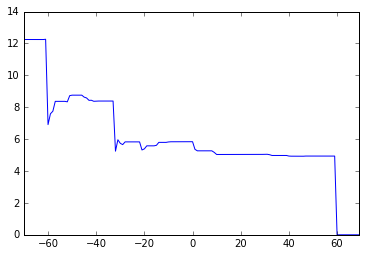

In [73]:
rmsfe.mean(axis=1).plot()

## Actual vs Prediction chart

In [76]:
actual = gdp.groupby(level="refDate").last()

In [84]:
# at 0 date
sieve = 0
vintagesOfInterest = {}
tempDir = {}
for gdpDate in gdpDates[5:]:
    vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
    forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction']["BZGDINDX Index"]
    forecast = forecast.loc[gdpDate]
    tempDir[gdpDate] = forecast

predict = pd.Series(tempDir)


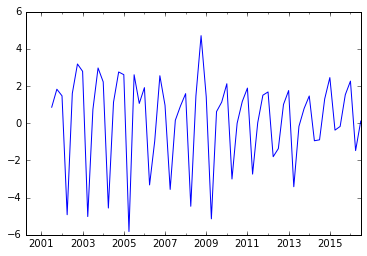

In [86]:
(predict-actual).plot()

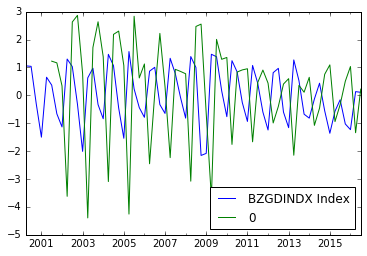

In [91]:
(pd.concat([actual,predict],axis=1)).plot()

In [80]:
vintagesOfInterest[dt.datetime(2016,11,29)]

Timestamp('2016-12-20 00:00:00')

In [85]:
listOfResults[vintagesOfInterest[dt.datetime(2016,11,29)]]['prediction']

,BZIPTLYo Index,MPMIBRMA Index,BZUETOTN Index,BFOETTOD Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,...,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX,BZGDINDX Index
2000-01-31,-0.291097,0.042421,0.039752,0.063437,0.104056,0.011364,0.431977,-0.252199,-0.074145,-0.144539,...,0.063233,-0.300091,-0.306281,-0.235293,-0.325154,0.020188,0.144544,-0.382306,-0.117575,0.214177
2000-02-29,0.621808,-0.090614,-0.084913,-0.135506,-0.222273,-0.024274,-1.506142,1.320503,0.170900,0.308738,...,-0.135070,1.182906,0.858100,0.502606,0.851717,-0.043123,-0.308759,0.816636,0.066661,0.117613
2000-03-31,0.221987,-0.032350,-0.030314,-0.048376,-0.079352,-0.008666,-0.853446,0.571225,0.086825,0.110215,...,-0.048220,0.041820,1.096984,0.179432,-0.164548,-0.015395,-0.110228,0.291542,0.278830,-0.037652
2000-04-30,-0.854376,0.124506,0.116672,0.186187,0.305407,0.033353,-0.051211,-0.578228,-0.121969,-0.424228,...,0.185589,-0.809702,-1.649797,-0.690588,-0.850857,0.059252,0.424241,-1.122074,-0.024076,0.049293
2000-05-31,1.048923,-0.152857,-0.143238,-0.228583,-0.374950,-0.040947,-4.688337,1.427010,1.134710,0.520805,...,-0.227848,1.071651,1.281271,0.847845,1.898712,-0.072744,-0.520843,1.377578,0.278789,0.268659
2000-06-30,-0.330351,0.048141,0.045112,0.071991,0.118088,0.012896,-0.798297,-0.374540,0.305793,-0.164041,...,0.071759,-0.244435,0.230025,-0.267013,-0.802429,0.022910,0.164036,-0.433859,-0.389031,1.053980
2000-07-31,-0.370023,0.053922,0.050530,0.080636,0.132269,0.014445,1.615889,0.165666,0.028334,-0.183742,...,0.080377,0.060701,-1.138238,-0.299065,-0.653087,0.025662,0.183735,-0.485961,0.233271,0.767190
2000-08-31,0.759663,-0.110703,-0.103738,-0.165547,-0.271551,-0.029655,1.360059,0.704044,-0.012996,0.377172,...,-0.165015,0.778222,1.512454,0.614098,1.211879,-0.052684,-0.377211,0.997685,-0.048203,0.915581
2000-09-30,-0.827782,0.120630,0.113040,0.180392,0.295901,0.032315,-0.798297,-1.265787,-0.554221,-0.411035,...,0.179812,-1.108618,-0.849202,-0.668918,-1.268891,0.057408,0.411036,-1.087148,-0.207582,1.038265
2000-10-31,0.355840,-0.051855,-0.048593,-0.077545,-0.127199,-0.013891,-1.414200,-0.201354,-1.878053,0.176659,...,-0.077296,0.319221,0.681794,0.288102,0.557019,-0.024678,-0.176692,0.467333,0.123092,0.582897


In [72]:
# WHAT WE WILL DO: Always pass a full calendar (even if full of NaNs) 
# and NaN everything after the cut calendar
pubDate = pubDates[1000]
cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
cutY = cutY.reindex(y.T.index)
tr = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)


In [73]:
tr['prediction'].columns

Index(['BZIPTLYo Index', 'MPMIBRMA Index', 'BZUETOTN Index', 'BFOETTOD Index',
       'BZREELHT Index', 'BPPICM Index', 'BZPIIPCM Index', 'BZEXTOT$ Index',
       'BZTBBALY INDEX', 'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX',
       'ibov index', 'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy',
       'BZMOTRFB INDEX', 'BZJCGTOT INDEX', 'BZEANSA INDEX', 'OEBRD002 INDEX',
       'BZGDINDX Index'],
      dtype='object')

In [74]:
gdpPred = tr['prediction']["BZGDINDX Index"]
gdp = yn.groupby(level="refDate").last()["BZGDINDX Index"]

gdpPred = gdpPred[~gdp.isnull()]
gdp = gdp[~gdp.isnull()]

In [75]:
(gdpPred-gdp)

2000-06-30    0.000000
2000-09-30    0.000000
2000-12-31    0.000000
2001-03-31    0.000000
2001-06-30    0.000000
2001-09-30    0.000000
2001-12-31    0.000000
2002-03-31    0.000000
2002-06-30    0.000000
2002-09-30    0.000000
2002-12-31    0.000000
2003-03-31    0.000000
2003-06-30    0.000000
2003-09-30    0.000000
2003-12-31    0.000000
2004-03-31    0.000000
2004-06-30    0.000000
2004-09-30    0.000000
2004-12-31    0.000000
2005-03-31    0.000000
2005-06-30    0.000000
2005-09-30    0.000000
2005-12-31    0.000000
2006-03-31    0.000000
2006-06-30    0.000000
2006-09-30    0.000000
2006-12-31    0.000000
2007-03-31    0.000000
2007-06-30    0.000000
2007-09-30    0.000000
2007-12-31    0.000000
2008-03-31    0.000000
2008-06-30    0.000000
2008-09-30    0.000000
2008-12-31    0.000000
2009-03-31    0.000000
2009-06-30    0.000000
2009-09-30    0.000000
2009-12-31    0.000000
2010-03-31    0.000000
2010-06-30    0.000000
2010-09-30    0.175795
2010-12-31    1.128773
2011-03-31 

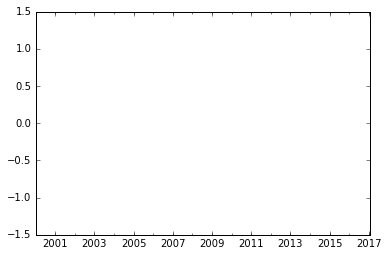

In [76]:
(tr['prediction']["BZGDINDX Index"] - yn.groupby(level="refDate").last()["BZGDINDX Index"]).plot()

In [77]:
x = robjects.r('print(kemfit,what=\'ytT\')')

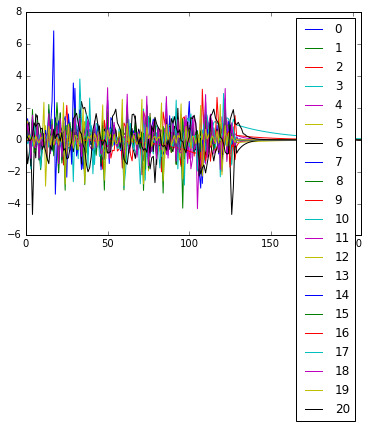

In [78]:
pd.DataFrame(x).T.plot()

In [79]:
y.T.shape

(206, 21)

In [80]:
robjects.r['states2']

rpy2.rinterface.NULL

In [81]:
ls[0]

 Volume in drive O is DATA
 Volume Serial Number is BA15-12EA

 Directory of O:\SALES\Fundos de Mercado\Notebooks\Nowcasting



File Not Found


In [82]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n,Z0i,x0i -o states,states1


# Zi=matrix(Zi,n,m)
# x0i=matrix(x0i,m,1)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)


# # Z0i=matrix(Z0i,n,1)
# Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

# # print(dim(Z0i))
# # print(dim(Zi))
# # print(dim(Bi))
# # print(dim(Qi))
# # print(x0i)

# print("START")

# # model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero"
# #                ,U="zero"
# #                ,R="diagonal and unequal")


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
#                ,x0=x0i
# #                ,x0="zero"
#                ,U="zero"
#                ,R="diagonal and equal")


# inits = list(Z=Z0i,x0=0)
# # print(Z0i)
# # print(Zi)
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
# #                                                 conv.test.slope.tol=0.00001,
# #                                                 abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=300
# #                                                 conv.test.slope.tol=0.3
# #                                                 abstol=0.5, 
# #                                                 allow.degen=TRUE
# #                                                 MCInit=TRUE,
# #                                                 numInits=100,
# #                                                 numInitSteps=20
#                                                            ))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=30))
# # kemfit = MARSS(yi, model=model.gen,inits=inits,fit=TRUE)
# # kemfit = MARSS(yi, model=model.gen,fit=FALSE)

# # print(kemfit$par$Z)
# states1 = kemfit$states
# states = print(kemfit)
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")